# 1. Read in Image, Grayscale and Blur

In [2]:
!pip install easyocr
!pip install imutils
!pip install pytesseract
!pip install tesseract
# !sudo apt install tesseract-ocr
# !sudo apt install libtesseract-dev

     |████████████████████████████████| 62.4MB 58kB/s 
  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=507ba1b6b50164a939b009097862414ba80fa6f39a12f1dec22883a959c1a035
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract
     |████████████████████████████████| 45.6MB 96kB/s 
  Created wheel for tesseract: filename=tesseract-0.1.3-cp36-none-any.whl size=45562571 sha256=ed57c60189f9090ae1bf5013f45902e509b2685d4dcdb6082aa631a59524abdd
  Stored in directory: /root/.cache/pip/wheels/82/1f/d9/24797b123379e4ea9511cf660835468b62dad609634cad2aba
Successfully built tesseract


In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import pytesseract

# Mount google drive to avoid session restart

In [69]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
haarcascade_licence_plate_rus_16stages.xml  img_4k_2.jpg  img_4k.png
haarcascade_russian_plate_number.xml	    img_4k_3.jpg  unnamed.jpg


In [70]:
%cd /content/gdrive/My Drive/Licenta/ColabStorage
!ls

/content/gdrive/My Drive/Licenta/ColabStorage
haarcascade_licence_plate_rus_16stages.xml  img_4k_2.jpg  img_4k.png
haarcascade_russian_plate_number.xml	    img_4k_3.jpg  unnamed.jpg


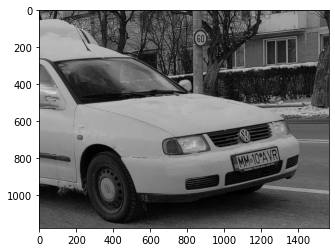

In [71]:
img = cv2.imread('img_4k_3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

# 2. Apply filter and find edges for localization


In [72]:
high_thresh, thresh_im = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
lowThresh = 0.5*high_thresh
print(high_thresh)
print(lowThresh)

91.0
45.5


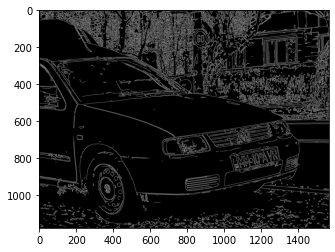

In [73]:
bfilter = cv2.bilateralFilter(gray, 4, 90, 90) #Noise reduction
edged = cv2.Canny(bfilter, lowThresh, high_thresh) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

# 3. Find Contours and Apply Mask


In [74]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
# contours

In [75]:
location = None
locations = []
for contour in contours:
    approx = cv2.approxPolyDP(contour, 18, True)
    if len(approx) == 4:
        location = approx
        locations.append(approx)
        break

In [76]:
location

array([[[1284,  745]],

       [[1294,  813]],

       [[1081,  858]],

       [[1065,  787]]], dtype=int32)

In [77]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

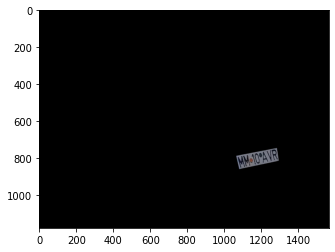

In [78]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [79]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

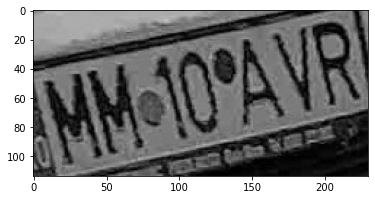

In [80]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

# 4. Use Easy OCR To Read Text

In [81]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[-5.9872611141445, 34.829299437467654],
   [231.7102375962423, -8.912408881293059],
   [241.9872611141445, 76.17070056253235],
   [3.2897624037576865, 119.91240888129306]],
  'MMQOAIR',
  0.05005580931901932)]

# 5. Render Result

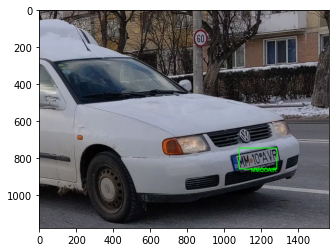

In [82]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0] - 140, approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))


# Try with pytesseract

In [ ]:
# Otsu's threshold
thresh2 = 255 - cv2.threshold(cropped_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(cv2.cvtColor(thresh2, cv2.COLOR_BGR2RGB))
# Blur and perform text extraction
thresh2 = cv2.GaussianBlur(thresh2, (1,1), 0)

data2 = pytesseract.image_to_string(thresh2, lang='eng', config='--psm 6')
data2

# Try cascade classifier for number plate

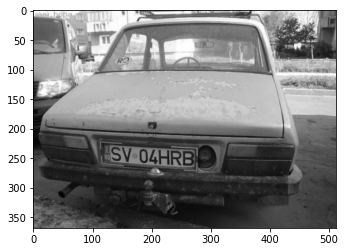

In [86]:
img2 = cv2.imread('unnamed.jpg')
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray2, cv2.COLOR_BGR2RGB))

[[123 216 163  54]]


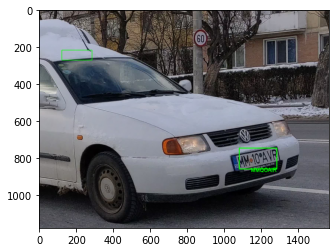

In [88]:
CASCADE_HAAR_CLASSIFIER = cv2.CascadeClassifier('haarcascade_russian_plate_number.xml')
licence_plate_detected = CASCADE_HAAR_CLASSIFIER.detectMultiScale(gray2, 1.1, 7)
res2 = img2
print(licence_plate_detected)

for (int32_x, int32_y, int32_w, int32_h) in licence_plate_detected:
  #cast to integer python
  x, y, w, h = int(int32_x), int(int32_y), int(int32_w), int(int32_h)
  res2 = cv2.rectangle(img,(x, y), (x + w, y + h), (0, 255 , 0), 2)
  # print('smth')
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))

              